In [145]:
import torch
from torch import nn
from torchsummary import summary

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from pathlib import Path
from zipfile import ZipFile
import requests

folder = Path("Deep learning datasets")
folder.mkdir(parents=True, exist_ok=True)
filename = "food-101.zip"

with open(folder / filename, 'wb') as file:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  file.write(request.content)


In [5]:
extracted_folder = Path("food-101-extracted")
extracted_folder.mkdir(parents=True, exist_ok= True)
with ZipFile(folder / filename, "r") as zip:
  zip.extractall(extracted_folder)

In [6]:
from pathlib import Path
import os
folder = Path("Deep learning datasets")
extracted_folder = Path("food-101-extracted")
for path, dirs, files in os.walk(folder / extracted_folder):
  print(f"{len(dirs)} directory(s) and {len(files)} file(s) present in {path}")

In [7]:
train = extracted_folder / "train"
test = extracted_folder / "test"

In [8]:
for _, _, files in os.walk(test):
  print(files)

[]
['684266.jpg', '988559.jpg', '2540511.jpg', '3196729.jpg', '2385731.jpg', '1230335.jpg', '858157.jpg', '2741434.jpg', '3837522.jpg', '719108.jpg', '2190404.jpg', '3806282.jpg', '2715127.jpg', '3177743.jpg', '1680893.jpg', '2394442.jpg', '2276986.jpg', '207578.jpg', '1987407.jpg', '175783.jpg', '343036.jpg', '887831.jpg', '46797.jpg', '499605.jpg', '1434806.jpg', '1600999.jpg', '1245193.jpg', '2521706.jpg', '1742201.jpg', '1172255.jpg', '479711.jpg']
['2144308.jpg', '354513.jpg', '1627703.jpg', '1302563.jpg', '2117351.jpg', '3873283.jpg', '1882831.jpg', '894825.jpg', '1016217.jpg', '673127.jpg', '966174.jpg', '690177.jpg', '296375.jpg', '27415.jpg', '100274.jpg', '1285886.jpg', '502076.jpg', '3424937.jpg', '1868005.jpg']
['2871261.jpg', '2124579.jpg', '309892.jpg', '2111981.jpg', '540882.jpg', '194643.jpg', '971934.jpg', '3092704.jpg', '714866.jpg', '2508636.jpg', '1152100.jpg', '2019408.jpg', '648055.jpg', '3475871.jpg', '398345.jpg', '416067.jpg', '2218680.jpg', '930553.jpg', '3443

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(42)

In [10]:
train_data = list(train.glob("*/*.jpg"))
test_data = list(test.glob("*/*.jpg"))

(512, 512, 3)


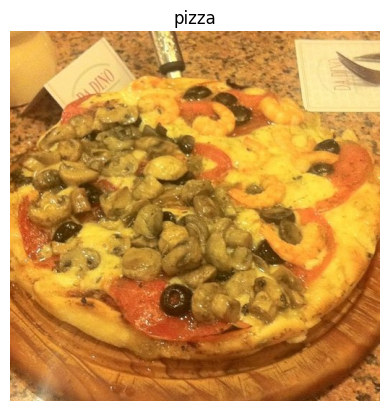

In [11]:
img_path = random.choice(train_data)
plt.title(img_path.parent.name)
img = plt.imread(img_path)
print(img.shape)
plt.imshow(img)
plt.axis(False)
plt.show()

In [12]:
dict({entry.name : idx for idx, entry in enumerate(os.scandir(train))})

{'sushi': 0, 'steak': 1, 'pizza': 2}

In [13]:
from torch.utils.data import DataLoader
from torchvision import transforms

In [14]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [15]:
from PIL import Image

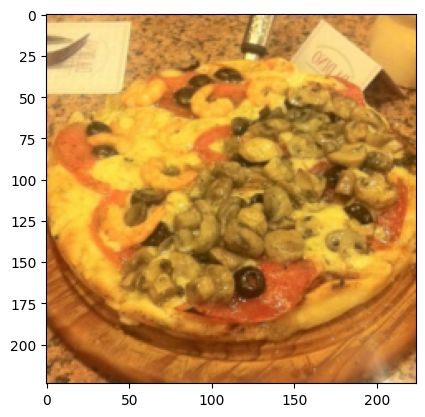

In [16]:
plt.imshow(data_transform(Image.open(img_path)).permute(1, 2, 0))

In [17]:
from torchvision import datasets

In [18]:
train

PosixPath('food-101-extracted/train')

In [19]:
train_dataset = datasets.ImageFolder(root = train, transform=data_transform)
test_dataset = datasets.ImageFolder(root = test, transform=data_transform)

In [20]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 225
    Root location: food-101-extracted/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [21]:
from torch.utils.data import DataLoader

In [98]:
train_dataloader = DataLoader(dataset = train_dataset, batch_size=32, shuffle=True, num_workers= 1)
test_dataloader = DataLoader(dataset = test_dataset, batch_size=32, shuffle=True, num_workers= 1)

In [128]:
from torchvision import models
model = models.efficientnet_v2_l(weights = models.EfficientNet_V2_L_Weights.DEFAULT)

In [ ]:
model.features

In [130]:
from torchinfo import summary

In [131]:
for param in model.parameters():
    param.requires_grad = False

In [132]:
classes = train_dataset.classes

In [133]:
model.classifier

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [134]:
classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace = True),
    nn.Linear(in_features=1280, out_features=len(classes), bias=True)
)
model.classifier = classifier

In [135]:
model = model.to(device)

In [136]:
summary(model)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 (864)
│    │    └─BatchNorm2d: 3-2                            (64)
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─FusedMBConv: 3-4                            (9,280)
│    │    └─FusedMBConv: 3-5                            (9,280)
│    │    └─FusedMBConv: 3-6                            (9,280)
│    │    └─FusedMBConv: 3-7                            (9,280)
│    └─Sequential: 2-3                                  --
│    │    └─FusedMBConv: 3-8                            (45,440)
│    │    └─FusedMBConv: 3-9                            (164,480)
│    │    └─FusedMBConv: 3-10                           (164,480)
│    │

In [137]:
from tqdm.auto import tqdm

In [138]:
from sklearn.metrics import accuracy_score

In [139]:
softmax = nn.Softmax(dim=1)

In [140]:
model.eval()
with torch.inference_mode():
    for X_test, y_test in tqdm(test_dataloader):
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        logits = model(X_test)
        print(accuracy_score(y_test.cpu(), softmax(logits).argmax(dim=1).cpu()))


  0%|          | 0/3 [00:00<?, ?it/s]

0.25
0.4375
0.18181818181818182


In [153]:
optimizer = torch.optim.Adam(params= model.parameters(), lr= 0.1)

In [155]:
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, last_epoch = 100)

In [156]:
loss_fn = torch.nn.CrossEntropyLoss()

In [157]:
epochs = 100

for epoch in tqdm(range(epochs), desc="Epochs"):
    
    model.train()
    train_loss = 0
    train_acc = 0
    for x_train, y_train in train_dataloader:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        acc = accuracy_score(y_train.cpu(), softmax(y_pred).argmax(dim=1).cpu())
        train_loss += loss
        train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    scheduler.step()

    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            logits = model(X_test)
            loss = loss_fn(logits, y_test)
            acc = accuracy_score(y_test.cpu(), softmax(logits).argmax(dim=1).cpu())
            test_loss += loss
            test_acc += acc
        test_loss = test_loss / len(test_dataloader)
        test_acc = test_acc / len(test_dataloader)
            

    if epoch % 10 == 0:
        print(f"[EPOCH : {epoch}] - train loss: {train_loss:.2f} | train acc: {train_acc * 100:.2f}% | test loss: {test_loss:.2f} | test acc: {test_acc * 100:.2f}%")

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

[EPOCH : 0] - train loss: 1.20 | train acc: 85.16% | test loss: 0.77 | test acc: 74.43%
[EPOCH : 10] - train loss: 2.21 | train acc: 77.34% | test loss: 1.27 | test acc: 90.72%
[EPOCH : 20] - train loss: 5.07 | train acc: 75.00% | test loss: 2.95 | test acc: 79.36%
[EPOCH : 30] - train loss: 1.32 | train acc: 82.03% | test loss: 1.71 | test acc: 90.62%
[EPOCH : 40] - train loss: 3.14 | train acc: 78.12% | test loss: 3.08 | test acc: 86.55%
[EPOCH : 50] - train loss: 5.78 | train acc: 75.39% | test loss: 2.65 | test acc: 90.62%
[EPOCH : 60] - train loss: 0.77 | train acc: 94.14% | test loss: 2.28 | test acc: 91.67%
[EPOCH : 70] - train loss: 0.68 | train acc: 96.88% | test loss: 1.99 | test acc: 86.65%
[EPOCH : 80] - train loss: 1.38 | train acc: 80.47% | test loss: 2.99 | test acc: 81.53%
[EPOCH : 90] - train loss: 5.87 | train acc: 79.30% | test loss: 1.97 | test acc: 89.68%


predicted: pizza | actual : pizza


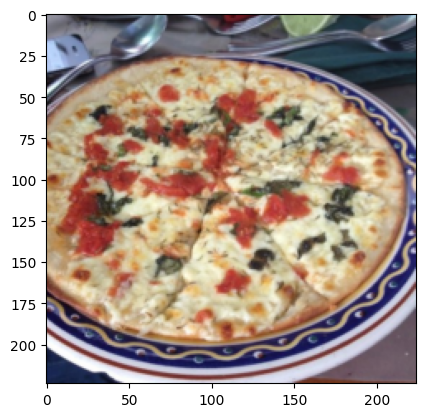

In [180]:
img, label = random.choice(train_dataset)
plt.imshow(img.permute(1,2,0))
model.eval()
with torch.inference_mode():
    X_test = img.unsqueeze(0).to(device)
    logits = model(X_test)
    predicted = classes[softmax(logits).argmax(dim=1)]
    print(f"predicted: {predicted} | actual : {classes[label]}")
#     print(accuracy_score(y_test.cpu(), softmax(logits).argmax(dim=1).cpu()))